In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/G-ZZ/jl_files/zz_samplers.jl")
include("temp.jl")

run_sampler (generic function with 3 methods)

#### Simulate data:

In [2]:
n_groups, group_size = 10, 100
Nobs = group_size*n_groups
d = 5
dim_total = 1+n_groups+d

σ02 = 1
my_pr = MM_prior(d, n_groups, σ02);

In [3]:
pX = 5e-2
X = spzeros(dim_total, Nobs)
X[1,:] = 1
for group in 1:n_groups
    X[group+1,((group-1)*group_size+1):(group*group_size)] = 1
end
X[n_groups+2:end,:] = sprandn(d, Nobs, pX)
ξ_true = rand(Normal(),dim_total)
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j])))) for j in 1:Nobs])
my_ll = ll_logistic_sp(X,y)
my_model = model(my_ll, my_pr);

#### Run sampler:

In [7]:
mb_size = 1
max_attempts = 5*10^6
prob_het = 0.99
adapt_speed = "none"

lambda = 3e1
start = time()
Print = true
run_sampler(my_model, lambda, max_attempts, mb_size, Print, prob_het, adapt_speed)
print("Time = ", round((time()-start)/60,1), " mins")

10 percent attempts in 1.28 min; zz bounces = 35493, hyp bounces = 2710, total time of process = 90.093 
20 percent attempts in 2.58 min; zz bounces = 70484, hyp bounces = 5375, total time of process = 180.243 
30 percent attempts in 3.91 min; zz bounces = 105199, hyp bounces = 8083, total time of process = 270.311 
40 percent attempts in 5.21 min; zz bounces = 140266, hyp bounces = 10822, total time of process = 360.364 
50 percent attempts in 6.55 min; zz bounces = 175490, hyp bounces = 13462, total time of process = 450.473 
60 percent attempts in 7.90 min; zz bounces = 210416, hyp bounces = 16237, total time of process = 540.562 
70 percent attempts in 9.20 min; zz bounces = 245497, hyp bounces = 18878, total time of process = 630.631 
80 percent attempts in 10.55 min; zz bounces = 280854, hyp bounces = 21528, total time of process = 720.535 
90 percent attempts in 11.95 min; zz bounces = 315843, hyp bounces = 24260, total time of process = 810.646 
100 percent attempts in 13.32 mi

### Plot ACFs:

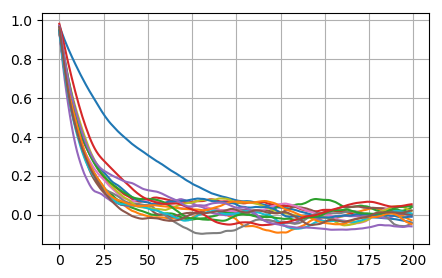

In [8]:
fig = figure("pyplot_barplot",figsize=(5,3))
n_samples = 10^4
maxlag_gzz = 200
acfs_gzz = zeros(dim_total,maxlag_gzz)
discard = 0
filename = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda)*
        "-dim_cov:"*string(d)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
xi_samples_gzz = extract_samples(xt_skel[:,discard+1:end], 
                             bt_skel[:,discard+1:end], 
                            (bt_skel[end]-bt_skel[discard+1])/n_samples,
                            "linear")[:,1:end-1]
for dim in 1:size(xi_samples_gzz,1)
    a = acf(xi_samples_gzz[dim,:],maxlag_gzz)
    plot(a)
    acfs_gzz[dim,:] = a
end
grid(true)
xt_skel, bt_skel, xi_samples = [], [], []
gc()

### Tune HMC:

In [9]:
ξ0 = randn(dim_total)
Total_time = 10
T = 250
Metropolise = false
Print = false
n_leapfrog_list = 20*(1:5)

20:20:100

In [10]:
for (i,n_leapfrog) in enumerate(reverse(n_leapfrog_list))
    start = time()
    prior = MM_prior(d, n_groups, σ02)
    my_ll = ll_logistic_sp(X,y)
    my_model = model(my_ll, prior)
    stepsize = Total_time/n_leapfrog
    xi_samples, hyper_samples, acc = 
    GibbsHMC(my_model, ξ0, stepsize, n_leapfrog, T, Metropolise, Print)
    print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
end

HMC acceptance = 100.0 percent; n_leapfrog = 100 in 0.38 mins 


LoadError: [91mArgumentError: Gamma: the condition α > zero(α) && θ > zero(θ) is not satisfied.[39m

In [11]:
Metropolise = true 
Print = false

stepsize = Total_time/90
total_times = 4*stepsize*(6:15)
n_leapfrog_steps = 5*(3:10)

for total_time in total_times
    print("Total time = ", round(total_time,2), "\n")
    for n_leapfrog in n_leapfrog_steps
        start = time()
        prior = MM_prior(d, n_groups, σ02)
        my_ll = ll_logistic_sp(X,y)
        my_model = model(my_ll, prior)
        a, b, c = 
        GibbsHMC(my_model, ξ0, total_time/n_leapfrog, n_leapfrog, 500, Metropolise, Print)
        print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
        if c > 0.7 
            break
        end
    end
end

Total time = 2.67
HMC acceptance = 0.2 percent; n_leapfrog = 15 in 0.12 mins 
HMC acceptance = 53.2 percent; n_leapfrog = 20 in 0.16 mins 
HMC acceptance = 87.6 percent; n_leapfrog = 25 in 0.2 mins 
Total time = 3.11
HMC acceptance = 0.4 percent; n_leapfrog = 15 in 0.12 mins 
HMC acceptance = 0.2 percent; n_leapfrog = 20 in 0.16 mins 
HMC acceptance = 59.6 percent; n_leapfrog = 25 in 0.2 mins 
HMC acceptance = 89.0 percent; n_leapfrog = 30 in 0.25 mins 
Total time = 3.56
HMC acceptance = 0.2 percent; n_leapfrog = 15 in 0.12 mins 
HMC acceptance = 0.2 percent; n_leapfrog = 20 in 0.16 mins 
HMC acceptance = 6.8 percent; n_leapfrog = 25 in 0.2 mins 
HMC acceptance = 65.4 percent; n_leapfrog = 30 in 0.23 mins 
HMC acceptance = 90.0 percent; n_leapfrog = 35 in 0.27 mins 
Total time = 4.0
HMC acceptance = 0.0 percent; n_leapfrog = 15 in 0.12 mins 
HMC acceptance = 0.2 percent; n_leapfrog = 20 in 0.15 mins 
HMC acceptance = 0.6 percent; n_leapfrog = 25 in 0.2 mins 
HMC acceptance = 50.6 perce

In [15]:
total_times_optimal = round.(total_times,2)
n_leapfrog_optimal =  [22,26,30,33,36,41,45,48,52,60];

In [16]:
T = 5000
Metropolise = true
Print = false

for (i,total_time) in enumerate(total_times_optimal) 
    n_leapfrog = n_leapfrog_optimal[i]
    start = time()
    prior = MM_prior(d, n_groups, σ02)
    my_ll = ll_logistic_sp(X,y)
    my_model = model(my_ll, prior)
    xi_samples_hmc, hyper_samples_hmc, acc =
    GibbsHMC(my_model, ξ0, total_time/n_leapfrog, n_leapfrog, T, Metropolise, Print)
    print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
    filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
                string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
                "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
    save(filename, "xi_samples", xi_samples_hmc, "hyper_samples", hyper_samples_hmc, "acc", acc)
    xi_samples_hmc, hyper_samples_hmc, acc = [], [], []
    gc()
end

HMC acceptance = 64.08 percent; n_leapfrog = 22 in 1.56 mins 
HMC acceptance = 67.18 percent; n_leapfrog = 26 in 1.81 mins 
HMC acceptance = 66.92 percent; n_leapfrog = 30 in 2.07 mins 
HMC acceptance = 63.74 percent; n_leapfrog = 33 in 2.27 mins 
HMC acceptance = 59.12 percent; n_leapfrog = 36 in 2.48 mins 
HMC acceptance = 63.14 percent; n_leapfrog = 41 in 2.8 mins 
HMC acceptance = 65.84 percent; n_leapfrog = 45 in 3.05 mins 
HMC acceptance = 60.5 percent; n_leapfrog = 48 in 3.2 mins 
HMC acceptance = 62.16 percent; n_leapfrog = 52 in 3.46 mins 
HMC acceptance = 83.2 percent; n_leapfrog = 60 in 3.99 mins 


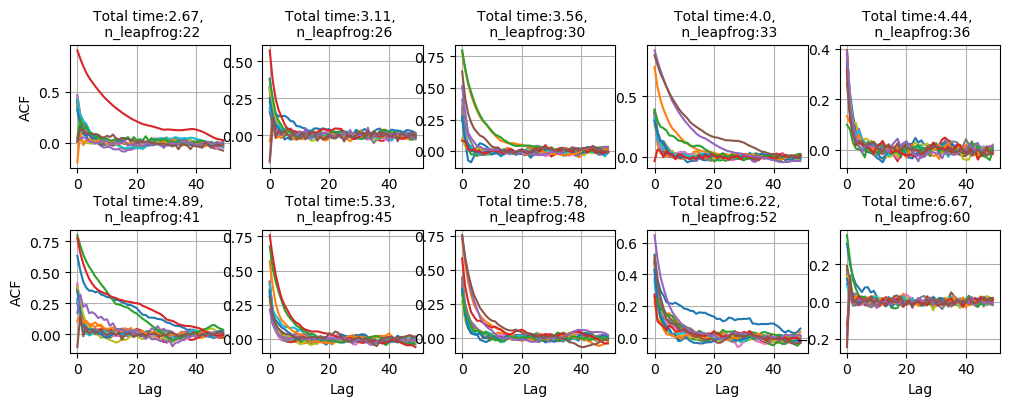

In [18]:
maxlag_hmc = 50
fig = figure(figsize=(12,4))
acfs_hmc = zeros(length(total_times_optimal),dim_total,maxlag_hmc)

for i in 1:2 
    for j in 1:5
        k = 5*(i-1)+j
        total_time, n_leapfrog = total_times_optimal[k], n_leapfrog_optimal[k]
        filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
                string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
                "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
        xi_samples_hmc = load(filename, "xi_samples")

        subplot(2,5,k)
        for dim in 1:size(xi_samples_hmc,1) 
            a = acf(xi_samples_hmc[dim,:], maxlag_hmc)
            plot(a)
            acfs_hmc[k,dim,:] = a
        end
        grid(true)  
        title("Total time:"*string(total_time)*", \n n_leapfrog:"*string(n_leapfrog), fontsize=10)
        xi_samples_hmc = []
        gc()
        if i == 2 xlabel("Lag") end
        if j == 1 ylabel("ACF") end
        subplots_adjust(hspace=0.5)
    end
end

In [19]:
T = 5000
maxlag_hmc_list = [50, 20, 30, 40, 10, 45, 25, 25, 50, 10]
hmc_mixing = zeros(length(total_times_optimal))
for i in 1:length(total_times_optimal)
    hmc_mixing[i] = T/maximum(sum(acfs_hmc[i,:,1:maxlag_hmc_list[i]],2))
end
hmc_cost = T*n_leapfrog_optimal*Nobs;

In [20]:
gzz_mixing = n_samples/maximum(sum(acfs_gzz[:,1:200],2))
gzz_cost = max_attempts*mb_size
minimum((gzz_mixing/gzz_cost)./(hmc_mixing./hmc_cost))

1.915648307184665

In [21]:
(gzz_mixing/gzz_cost)./(hmc_mixing./hmc_cost)

10-element Array{Float64,1}:
 15.3888 
  2.68287
  8.45843
 17.9458 
  1.91565
 23.1193 
  9.76903
 11.1778 
 19.2968 
  3.57097